# DNN - HMM Hybrid Speech Recognition

In this exercise we use a deep feedforward neural net as acoustic model and feed the outputs of it to an HMM system to build a full 
speech recognition system

We use an acoustic model trained in ch4_class/ex_timit-3.ipynb
The posterior probabilities were precomputed for a couple of example sentences.

For reference also a GMM model (also trained in the same exercise) is applied to the same data.

In [1]:
# do all the imports
try:
  import pyspch
except:
  ! pip install git+https://github.com/compi1234/pyspch.git

%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

from pyspch import libhmm 
from pyspch import Densities
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

# graphical and print preferences
cmap_car = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]
#cmap="OrRd_r"
pd.options.display.float_format = '{:,.3f}'.format
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlepad'] = 14
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rc('lines', linewidth=2, color='k')

In [4]:
# using TIMIT-48 as baseline phone set
# make also phone <--> index mapping dictionaries
phn_set = np.array(Spch.TIMIT48)
phn2lab_map = {phn : i for i, phn in enumerate(phn_set) }
lab2phn_map = {i : phn for i, phn in enumerate(phn_set) }    

# convert array of phones into index array usable for slicing
def phn2indx(arr,phn_set=phn_set):
    phn_map = {phn : i for i, phn in enumerate(phn_set) }
    return np.array([ phn_map[p] for p in arr ])


# convert a segmentation in DataFrame format to a label sequence
def seg2lbls(seg,shift=0.01):
    '''
    Convert segmentation dataframe to a label sequence
    
    Returns (frame_indices, frame_labels)
    
    The segmentation needs not be complete, some frame indices may be missing
    If the segmentation is complete - i.e. from first to last frame - then frame_labels can be
    used as an alignment of the full utterance
    '''
    fr_indx = []
    lbls = []
    for indx in seg.index:
        i1 = round((seg['t0'][indx])/shift)
        i2 = round(seg['t1'][indx]/shift)
        for i in range(i1,i2):
            fr_indx.append(i)
            lbls.append(seg['seg'][indx])
    return(fr_indx,lbls)

def lbls2df(lbls,shift=0.01,style="seg"):
    '''
    convert a label sequence to a segmentation or label DataFrame (style="seg" or "lbl")
    This conversion assumes all frames to be labeled
    
    '''
    if style == "seg":
        t1 = []
        t0 = [ 0. ]
        seg = [ lbls[0] ]
        for i in range(1,len(lbls)):
            if lbls[i] != lbls[i-1]:
                t0.append( i*shift )
                seg.append(lbls[i])
                t1.append( i*shift )
        t1.append( len(lbls) * shift )
        return( pd.DataFrame({'t0':t0,'t1':t1,'seg':seg}) )
    
    elif style == "lbl":
        t = np.arange(len(lbls))*shift+0.5*shift
        return( pd.DataFrame({'t':t,'lbl':lbls}) )



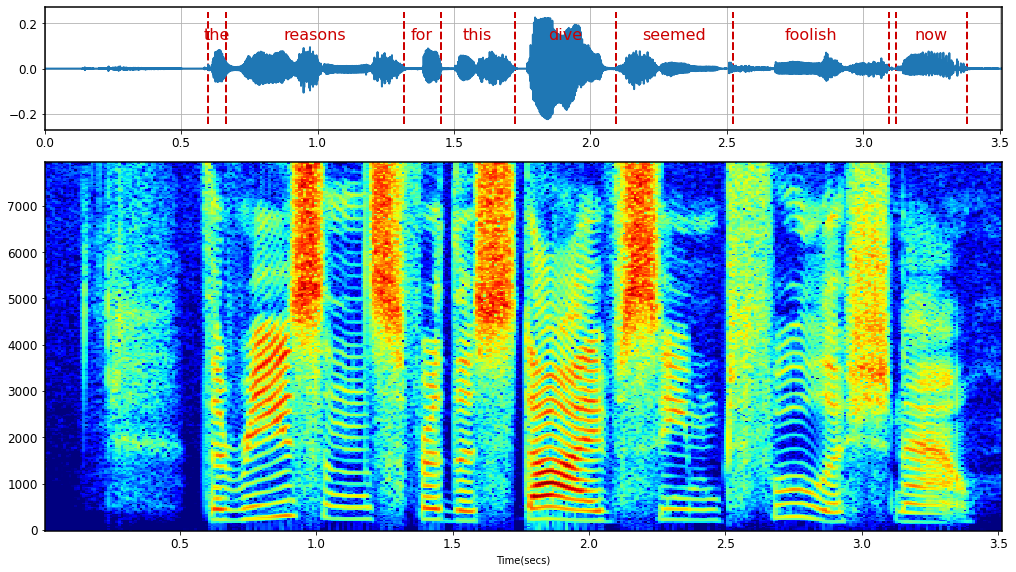

In [12]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/test/'
corpus= ['dr1/faks0/si2203', 'dr4/fadg0/si1279',  'dr8/fcmh1/si1493']
example = 0
name = corpus[example]

if example == 0:    # segment selection "the reasons for this dive"
    phn_sel = np.array(['sil','cl','vcl','d','dh','z','s','f','er','ay','aa','ih','iy'])
    frames=[45,215]
elif example == 2:  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','vcl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    frames=[0,150]
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spch.load(wavfname)
dt = 1./sr
xlat ='timit61_48'

# get phone and word segmentations and convert also to a phoneme alignment
seg_phn = Spch.read_seg_file(dir+name+ ".phn",dt=dt,fmt='float32',xlat=xlat)
seg_wrd = Spch.read_seg_file(dir+name+ ".wrd",dt=dt,fmt='float32',xlat=xlat)
_, y_ref = seg2lbls(seg_phn)

# compute a spectrogram with default parameters
shift=0.01
length=0.03
n_mels = None
dy = None if n_mels is None else 1.
n_shift = int(shift*sr)
n_length = int(length*sr)
spgdata = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=n_mels)
(nparam,nfr)=spgdata.shape
d_freq = sr/(2.*(nparam-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spgdata,segwav=seg_wrd,sample_rate=sr,dy=dy,figsize=(14,8))
fig

## Load the precomputed frame probabilities
Baseline feature extraction is an 80-channel mel filterbank.   
Frame probabilities are computed in 2 acoustic models:  
1. a DNN using a window of 11 frames and stride 2
2. a GMM using a single frame spectral input


### Some helper routines

In [13]:
def read_probs_from_file(name):
    filename = name + "-dnn_f11s2-postprobs" + ".csv"
    prob_dnn = np.loadtxt(filename, delimiter="\t")
    filename = name + "-gmm_f1-postprobs" + ".csv"
    prob_gmm = np.loadtxt(filename, delimiter="\t")
    return (prob_dnn,prob_gmm)


def plot_probs(probs,iax=2,x0=0.,title="",style="line"):
    #probs = probs[frames[0]:frames[1],phn2indx(phn_sel)]
    ax = fig.axes[iax]
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T,ax=ax,yticklabels=plt_phones,cmap=cmap_jet2)
        ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T,iax=iax,x0=x0,dx=.01,yrange=[0.,1.])
        fig.axes[iax].legend(plt_phones,loc='center right')
    ax.set_title(title)

### Now import the probability features
also define a selection of frames and phones for plotting purposes

We plot both the posteriors computed by the DNN and the posteriors computed by the GMM.   
On the first plot we also show the hand made word and phone segmentations 

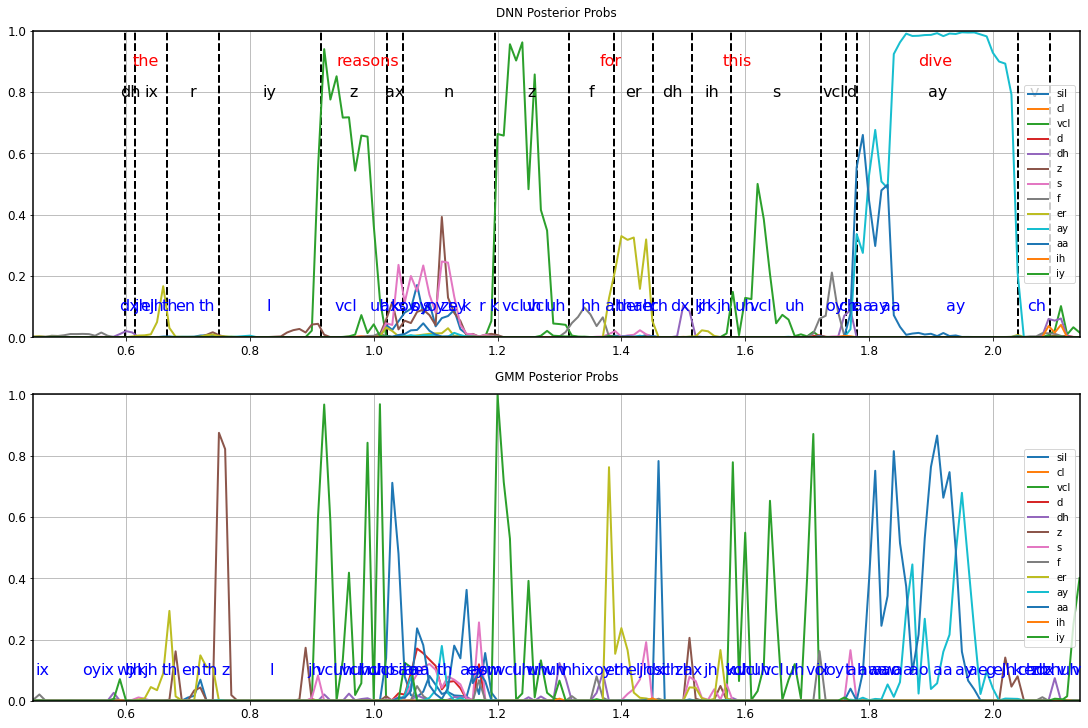

In [14]:
prob_dnn, prob_gmm = read_probs_from_file(dir+name)
y_dnn = phn_set[np.argmax(prob_dnn, axis=1)]
y_gmm = phn_set[np.argmax(prob_gmm, axis=1)]
#
#df_dnn = pd.DataFrame(prob_dnn, columns=phn_set)[phn_sel]
#df_gmm = pd.DataFrame(prob_gmm, columns=phn_set)[phn_sel]

plt_phones = phn_sel
indx_sel = phn2indx(phn_sel)
frame_sel = slice(frames[0],frames[1])
plt_frames = frames

prob_dnn_sel = prob_dnn[frame_sel,indx_sel]
prob_gmm_sel = prob_gmm[frame_sel,indx_sel]

fig = Spd.SpchFig(row_heights=[1]*2,figsize=(15,10))
plot_probs(prob_dnn_sel,iax=0,x0=frames[0]*.01,style="line",title="DNN Posterior Probs")
plot_probs(prob_gmm_sel,iax=1,x0=frames[0]*.01,style="line",title="GMM Posterior Probs")
fig.add_seg_plot(seg_phn,iax=0,ypos=.8,color='k')
fig.add_seg_plot(seg_wrd,iax=0,ypos=.9,Lines=False,color='r')

y_dnn_seg = lbls2df(y_dnn)
fig.add_seg_plot(y_dnn_seg,iax=0,ypos=.1,Lines=False,color='b')
y_gmm_seg = lbls2df(y_gmm)
fig.add_seg_plot(y_gmm_seg,iax=1,ypos=.1,Lines=False,color='b')
fig

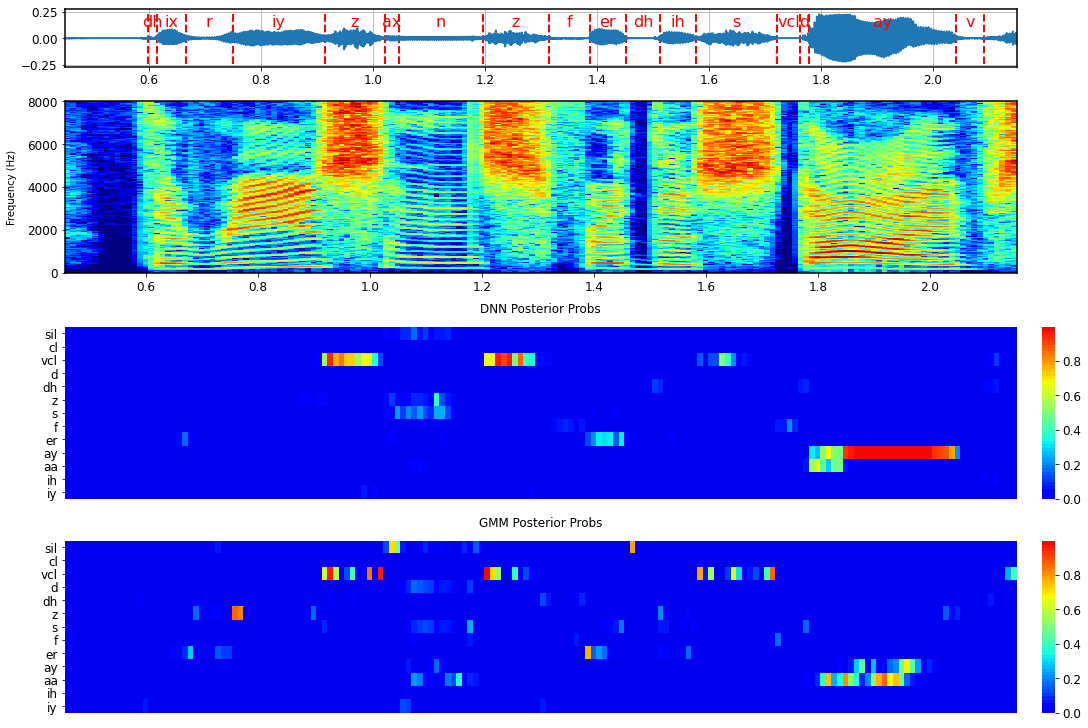

In [15]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),
                  img_ftrs=[None,None])
fig.add_seg_plot(seg_phn,iax=0,ypos=0.8)
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
plot_probs(prob_gmm_sel,iax=3,style="img",title="GMM Posterior Probs")
fig

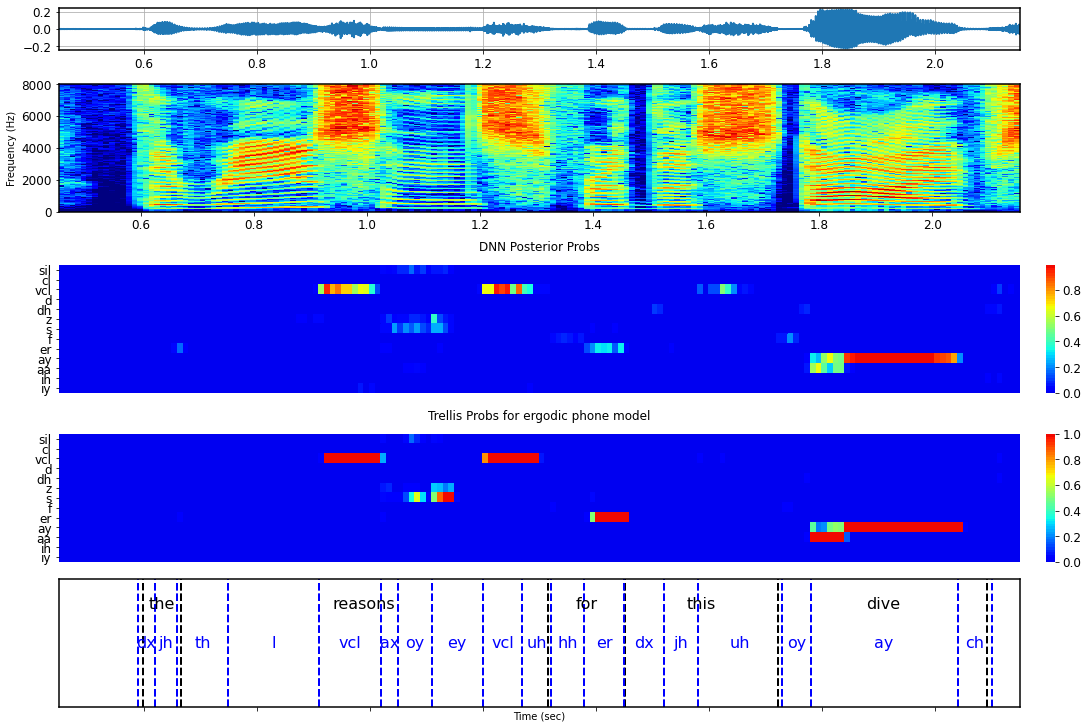

In [17]:
obs1 = Densities.Prob(style="Probs")
hmm1 = libhmm.HMM(prob_style="lin",obs_model=obs1,states=phn_set)
hmm1.init_topology("ergodic",selfprob=.5)
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(prob_dnn)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),
                  img_ftrs=[None,None,None])
#tr_probs_sel = selection(trellis1.probs,frames=frames,phn_sel=phn_sel)
tr_probs_sel = trellis1.probs[frame_sel,indx_sel]
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
plot_probs(tr_probs_sel,iax=3,style="img",title="Trellis Probs for ergodic phone model")
fig.add_seg_plot(seg_wrd,iax=4,ypos=0.8,color='k')

y_viterbi = trellis1.backtrace()
y_vit_seg = lbls2df(phn_set[y_viterbi])
fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b')

fig

## Adding linguistic knowledge

We can help the recognizer significantly by provinding linguistic information 
in the sense of which phonemes are likely to follow one another, and what words can follow each other

In this notebook we just illustrate how certain info can be added in a very ad hoc way.   
We construct a phone bigram LM from a tiny example dictionary.

In [18]:
def phone_lm_from_lex(lexicon,phn_set,phn_length=5):
    '''
    A phone bigram is trained from a lexicon.
    Silence is allowed between words and thus added as a word start or word en option
    Sentences are forced to start or end in silence
    '''
    all_data = ['sil']
    for _,w in lexicon.items(): all_data = all_data + w + ['sil']
    for _,w in lexicon.items(): all_data = all_data + w 
    #phn_list = np.unique( np.array(all_data) )
    n_phones = len(phn_set)
    # initialize with unigram counts 2
    avg_ct = len(all_data) // n_phones
    bigram_cts = avg_ct*phn_length*np.eye( n_phones , dtype='int64')

    data = phn2indx(all_data,phn_set=phn_set)
    for i in range(len(data)-1):
        bigram_cts[data[i],data[i+1]] += 1
    
    bigrams = bigram_cts / np.sum(bigram_cts,axis=1)
    return(bigrams)

In [19]:
lexicon = {
    'the': ['dh','ix'],
    'reasons': ['r','iy','z','ax','n','z'],
    'for': ['f','er'],
    'this': ['dh','ih','s'],
    'dive': ['vcl','dh','ay','v'],
    'seemed': ['s','iy','m','vcl','d'],
    'foolish': ['f','uw','l','ix','sh'],
    'now': ['n','aw'],
    'by' : ['b','ay'], 
    'that' : ['dh','ae','cl','t'],
    'time' : ['t','ay','m'],
    'perhaps': ['cl','p','er','hh','ae','cl','p','s'],
    'something': ['s','ah','m','th','iy','ng'],
    'better': ['vcl','b','eh','dx','er'],
    'can': ['cl','k','ix','n'],
    'be': ['vcl','b','iy'],
    'done': ['vcl','d','ah','n']
}
tmat_phn_bigram = phone_lm_from_lex(lexicon,phn_set=phn_set) + 1.e-10

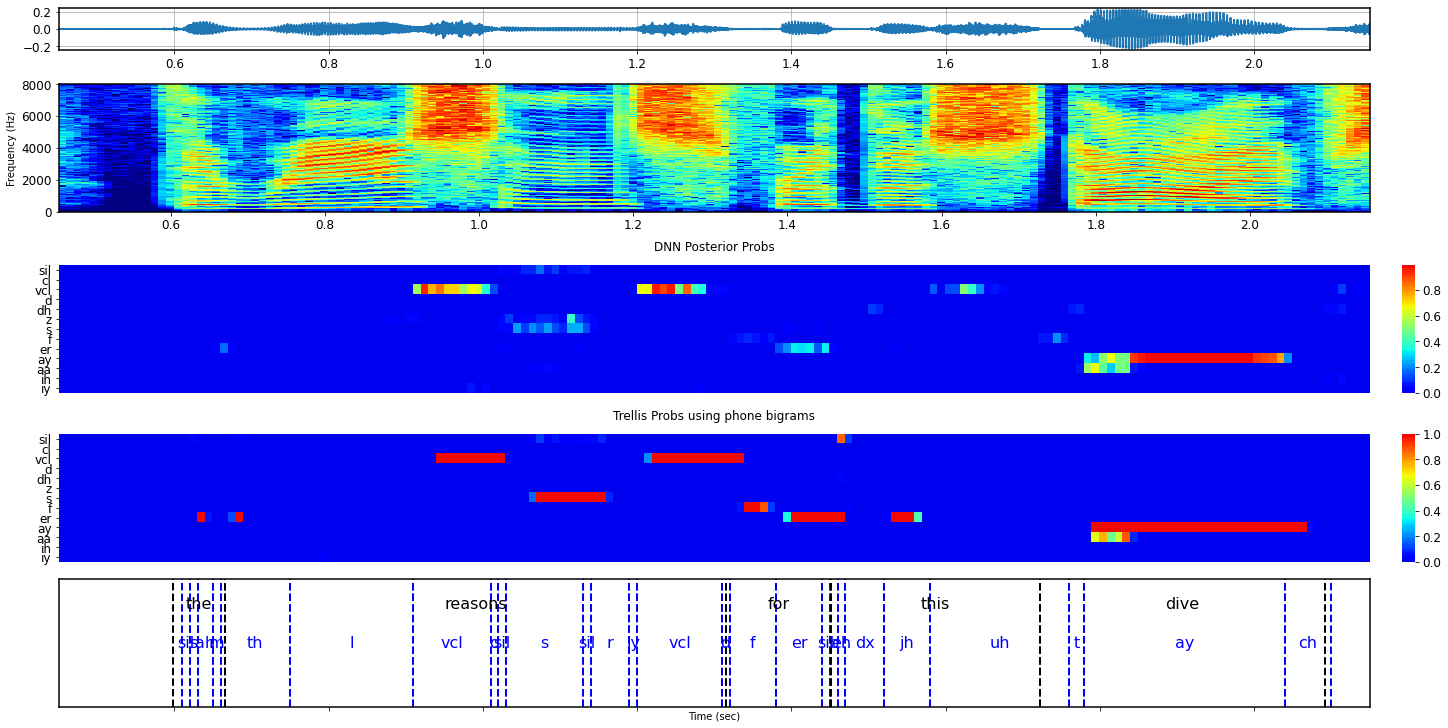

In [21]:
hmm2 = libhmm.HMM(prob_style="lin",obs_model=obs1,states=phn_set,transmat=tmat_phn_bigram)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(prob_dnn)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(20,10),
                  img_ftrs=[None,None,None])
#tr_probs_sel = selection(trellis2.probs,frames=frames,phn_sel=phn_sel)
tr_probs_sel = trellis2.probs[frame_sel,indx_sel]
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
plot_probs(tr_probs_sel,iax=3,style="img",title="Trellis Probs using phone bigrams")


y_viterbi = trellis2.backtrace()
y_vit_seg = lbls2df(phn_set[y_viterbi])
fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b')
fig.add_seg_plot(seg_wrd,iax=4,ypos=0.8,color='k')
fig